In [26]:
import os
os.chdir('../')
import numpy as np 
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

import psycopg2
from contextlib import closing
import pandas as pd
from trade_assistant.consts import (
    CoinTable,
    POSTGRESQL_CONFIG_FILE,
)
from trade_assistant.database.db import PostGresLocalDatabase
from psycopg2 import sql
from trade_assistant.utils.utils import read_yml_config
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list


In [2]:
postgresql_db_config = read_yml_config(POSTGRESQL_CONFIG_FILE)
conn = psycopg2.connect(**postgresql_db_config)

In [3]:
# Sample stock list
# selected based on my own interest.
STOCK_LISTS = [
    "ACB", "TCB", "SHS", "MSN",
    "HAG", "NVL", "SSI", "BCM",  
    "BID", "BVH", "FPT", "HPG", "HSG",
    "NKG", "KBC", "VIC", "POW",
    "VIB", "VPB", "PNJ", "MSB",
    "SSB", "NVL", "PDR", "REE",
    "EIB"
]

In [8]:
GET_STOCK_QUERY = """
        SELECT *, cast(extract(hour from to_timestamp(created_at)) as int)
        FROM {table_name}
        WHERE {fields} = {field_value}
        and {trade_date} >= {start_date} and {trade_date} <= {end_date}
"""


def get_stock_data(ticker, start_date, end_date,):
    """
    Get the ticker data from my db, given start and end date
    This is applied for eod table, for minute-based table 
    it should have other input params
    """
    query = sql.SQL(GET_STOCK_QUERY).format(
        table_name = sql.Identifier(TABLE_NAME),
        fields = sql.Identifier(FIELDS),
        field_value=sql.Literal(ticker),
        trade_date=sql.Identifier(TRADE_DATE),
        start_date=sql.Literal(start_date),
        end_date=sql.Literal(end_date)
    )
    
    with conn.cursor() as cursor:
        cursor.execute(query)
        result = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
    return pd.DataFrame(result, columns=columns)

In [9]:
TABLE_NAME = "stock_trading_eod"
FIELDS = 'ticker'
TRADE_DATE = "trading_date"
END_DATE = "2025-01-16"
CREATED_AT = "created_at"
START_DATE = '2021-03-24'
END_DATE = '2024-10-25'

stock_data_dictionary = {}
for ticker in STOCK_LISTS:
    df = get_stock_data(ticker, START_DATE, END_DATE)
    stock_data_dictionary[ticker] = df

In [10]:
for i in stock_data_dictionary.keys():
    df = stock_data_dictionary[i].dropna()
    print(i, df.shape)

ACB (897, 9)
TCB (897, 9)
SHS (897, 9)
MSN (897, 9)
HAG (897, 9)
NVL (1794, 9)
SSI (897, 9)
BCM (897, 9)
BID (897, 9)
BVH (897, 9)
FPT (897, 9)
HPG (897, 9)
HSG (897, 9)
NKG (897, 9)
KBC (897, 9)
VIC (897, 9)
POW (897, 9)
VIB (897, 9)
VPB (897, 9)
PNJ (897, 9)
MSB (897, 9)
SSB (897, 9)
PDR (897, 9)
REE (897, 9)
EIB (897, 9)


In [14]:
# processing the NVL data
nvl_df = stock_data_dictionary['NVL']
nvl_df.trading_date.value_counts()

trading_date
2021-03-24T00:00:00.000Z    2
2023-01-05T00:00:00.000Z    2
2023-08-03T00:00:00.000Z    2
2023-08-04T00:00:00.000Z    2
2023-08-07T00:00:00.000Z    2
                           ..
2022-06-10T00:00:00.000Z    2
2022-06-13T00:00:00.000Z    2
2022-06-14T00:00:00.000Z    2
2022-06-15T00:00:00.000Z    2
2024-10-24T08:00:00.000Z    2
Name: count, Length: 897, dtype: int64

In [15]:
nvl_df.loc[nvl_df.trading_date == '2021-03-24T00:00:00.000Z']

,open,high,low,close,volume,trading_date,created_at,ticker,extract
0,44904.0,45016.0,44566.0,44904.0,1841200.0,2021-03-24T00:00:00.000Z,1701022345,NVL,18
671,44904.0,45016.0,44566.0,44904.0,1841200.0,2021-03-24T00:00:00.000Z,1701035957,NVL,21


In [16]:
# 
stock_data_dictionary['NVL'] = stock_data_dictionary['NVL'].drop_duplicates(['trading_date'])

In [17]:
def populate_roc(df, close_col, window=1):
    """
    Calculate returns 
    """
    diff = df[close_col].diff(window).dropna()
    roc = (diff / df[close_col]).shift(window) * 100
    
    df[f'roc_{window}'] = roc
    return roc

for k in stock_data_dictionary.keys():
    df = stock_data_dictionary[k]
    df = populate_roc(df, 'close', 1)

/var/folders/t6/bc8yn9_952z8gsf74_gy24z80000gn/T/ipykernel_55091/3512250587.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'roc_{window}'] = roc


In [20]:
list_returns = []
for stock in stock_data_dictionary.values():
    roc = stock.dropna()['roc_1'].values.reshape(1, -1)  # Ensure 2D array
    list_returns.append(roc)

returns_mat = np.concatenate(list_returns)

<Axes: >

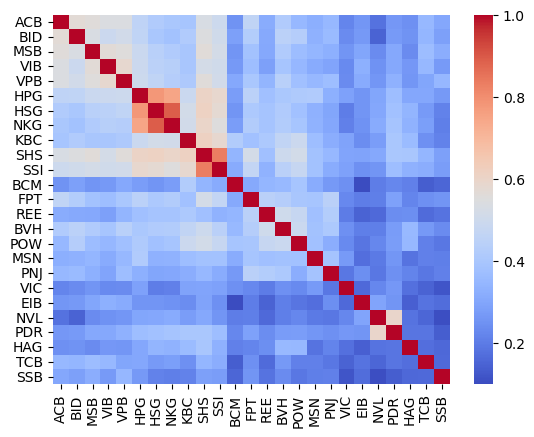

In [27]:
# Create a DataFrame from the return matrix for correlation calculation
returns_df = pd.DataFrame(returns_mat.T)
returns_df.columns = list(stock_data_dictionary.keys())


# Calculate the correlation matrix
correlation_matrix = returns_df.corr()

# # Plot the correlation matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0, cbar=True)
# plt.title("Correlation Matrix of Asset Returns")
# plt.show()


# hierarchical clustering
linkage_matrix = linkage(correlation_matrix, method='average')
ordered_indices = leaves_list(linkage_matrix)

# Reorder correlation matrix
ordered_corr = correlation_matrix.iloc[ordered_indices, ordered_indices]

# Plot reordered heatmap
sns.heatmap(ordered_corr, cmap="coolwarm", xticklabels=True, yticklabels=True)

In [64]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph_from_correlation_matrix(correlation_matrix, stock_names, threshold=0.4):
    """
    Create a graph based on the correlation matrix where edges are added for weights above a threshold.
    """
    G = nx.Graph()
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            weight = correlation_matrix.iloc[i, j]
            if abs(weight) > threshold:
                G.add_edge(stock_names[i], stock_names[j], weight=weight)
            else:
                # seems inefficient here - should put in other way
                G.add_node(stock_names[i])
    return G

def normalize_weights(weights):
    """
    Normalize weights for opacity and thickness scaling.
    """
    max_weight = max(abs(w) for w in weights) if weights else 1
    min_weight = 0
    normalized_opacity = [(abs(w) - min_weight) / (max_weight - min_weight) for w in weights]
    # multiply by 3 just for thickness increase
    normalized_thickness = [(abs(w) - min_weight) / (max_weight - min_weight)*3 for w in weights]
    return normalized_opacity, normalized_thickness

def draw_graph(G, k=0.7):
    """
    Visualize the graph with normalized edge weights as varying opacity and thickness.
    """
    edges = G.edges(data=True)
    weights = [d['weight'] for (_, _, d) in edges]
    
    # Normalize weights
    normalized_opacity, normalized_thickness = normalize_weights(weights)
    
    # Generate positions for nodes
    pos = nx.spring_layout(G, k=k)
    
    # Draw edges with varying opacity and thickness
    plt.figure(figsize=(12, 10))
    for (u, v, d), opacity, thickness in zip(edges, normalized_opacity, normalized_thickness):
        color = "red" if d["weight"] < 0 else "gray"
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            width=thickness,
            alpha=opacity,
            edge_color=color,
        )
    
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    plt.title("Asset Correlation Network with Edge Opacity")
    plt.show()

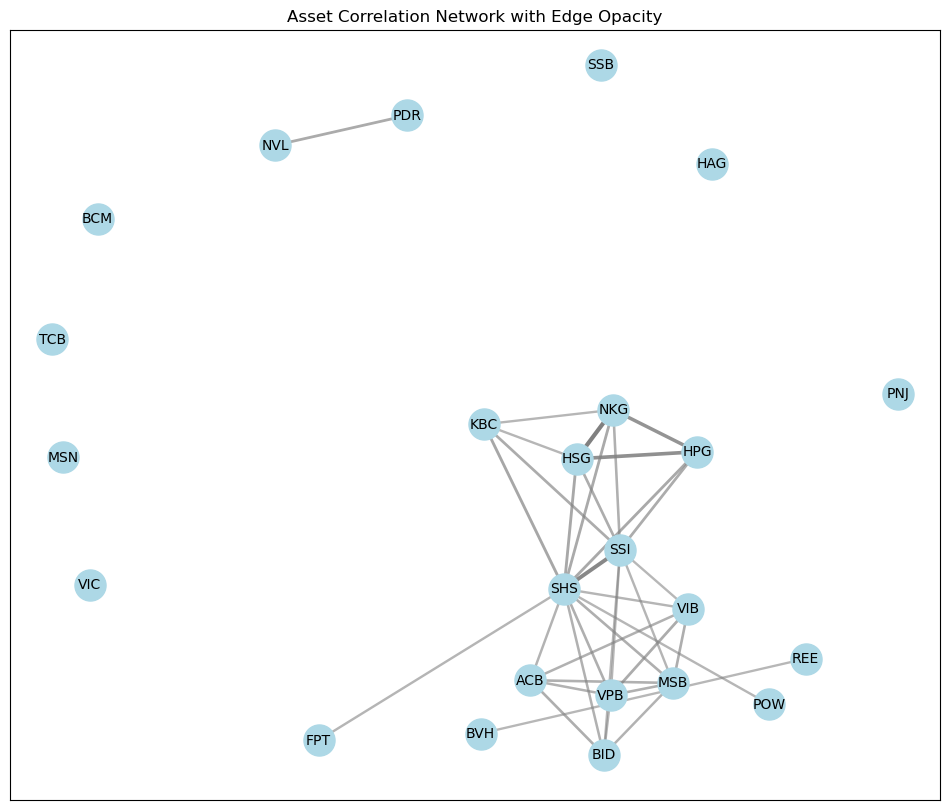

In [63]:
def make_graph(correlation_matrix, stock_names, threshold=0.4):
    """
    Main function to create and visualize the asset correlation graph.
    """
    G = create_graph_from_correlation_matrix(correlation_matrix, stock_names, threshold)
    draw_graph(G)
make_graph(correlation_matrix, list(returns_df.columns), threshold=0.5)

It makes some senses for NKG - HSG - HPG as they are big corps in the same industries (steel). Also for NVL - PDR (real estate) & VIB - ACB - VPB - MSB - BID (banking industry).